## Reinforcement Learning Final Projet

**Project: Exploring and Comparing contextual bandits with linear UCB and linear Thompson Sampling**

---

**Authors:Oliver Tausendschoen, Marvin Ernst, Timothy Cassel**

**Due Date: 02 July, 2025**

---

#### Library imports 

In [1]:
# General 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# obp imports 
from obp.dataset import SyntheticBanditDataset, logistic_reward_function
from obp.policy import LinTS, LinUCB, LinEpsilonGreedy

from obp.ope import OffPolicyEvaluation, ReplayMethod
from obp.simulator import calc_ground_truth_policy_value, run_bandit_simulation

import warnings
warnings.filterwarnings('ignore')

### Experiment Parameters

### Dataset (from OpenBanditPipeline)

In this notebook, we use the synthetic OBP class to generate a synthetic dataset similar to the real one, but this allows us to have ground-truth rewards. 

- **Type**: Synthetic contextual bandit  
- **Arms (actions)**: 10  
- **Context dimension**: 5 (features drawn from a standard normal distribution)  
- **Reward model**: Logistic function $q(x,a)$ with per-arm parameter vectors  
- **Behavior policy**: Uniformly random (each arm $a$ chosen with $p=1/10$  

In [2]:
# Set up experiment parameters (same as real sample dataset)
n_rounds = 10000      # sample size of logged bandit data
n_actions = 10        # number of actions
dim_context = 5       # dimensions of context vectors
n_sim = 50             # number of simulations to calculate ground truth policy values
random_state = 12345

np.random.seed(random_state)

In [3]:
print(f"- Number of rounds: {n_rounds}")
print(f"- Number of actions: {n_actions}")
print(f"- Context dimension: {dim_context}")
print(f"- Ground truth simulations: {n_sim}")
print(f"- Random state: {random_state}")

- Number of rounds: 10000
- Number of actions: 10
- Context dimension: 5
- Ground truth simulations: 50
- Random state: 12345


In [49]:
dataset = SyntheticBanditDataset(
    n_actions=n_actions,
    dim_context=dim_context,         
    reward_function=logistic_reward_function,
    behavior_policy_function=None,
    random_state=random_state,
)
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)


### Exploring the synthetic dataset

In [50]:
df = pd.DataFrame({
    'action': bandit_feedback['action'],
    'reward': bandit_feedback['reward'],
    'pscore': bandit_feedback['pscore'],  # propensity under the random policy
    **{f'ctx_{i}': bandit_feedback['context'][:, i]
       for i in range(bandit_feedback['context'].shape[1])}
})

In [51]:
print(df.shape)   # e.g. (5000, dim_context + 3)
print(df.head())

(10000, 8)
   action  reward  pscore     ctx_0     ctx_1     ctx_2     ctx_3     ctx_4
0       6       1     0.1 -0.204708  0.478943 -0.519439 -0.555730  1.965781
1       4       1     0.1  1.393406  0.092908  0.281746  0.769023  1.246435
2       2       1     0.1  1.007189 -1.296221  0.274992  0.228913  1.352917
3       8       0     0.1  0.886429 -2.001637 -0.371843  1.669025 -0.438570
4       6       1     0.1 -0.539741  0.476985  3.248944 -1.021228 -0.577087


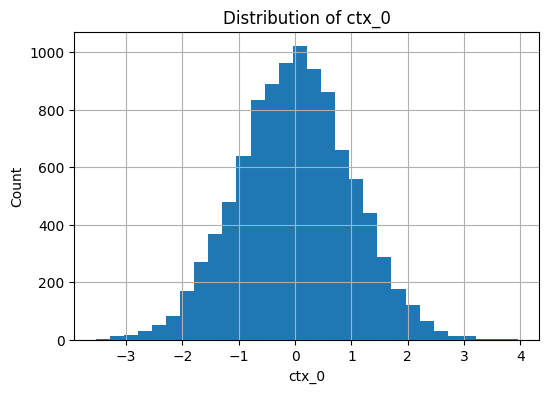

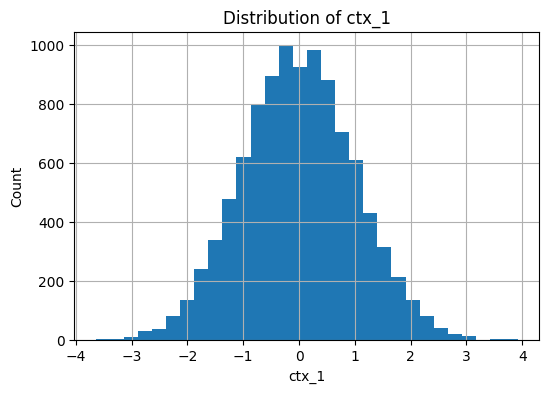

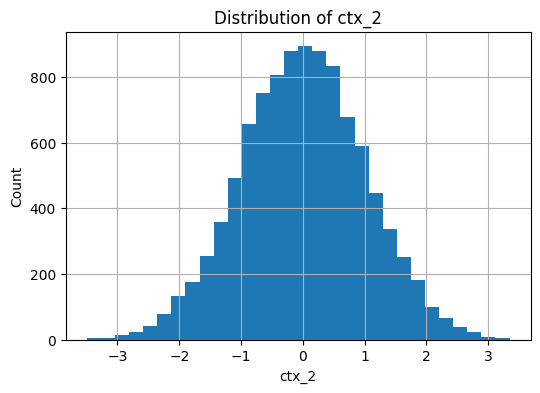

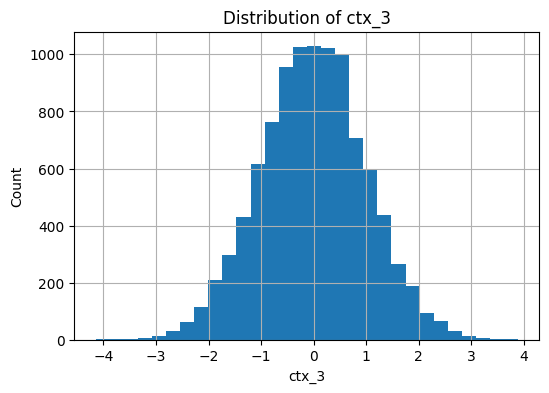

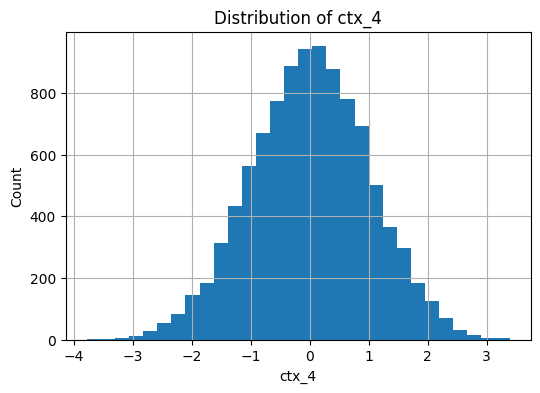

In [52]:
# context columns
context_cols = [c for c in df.columns if c.startswith('ctx_')]

# Check that the context columns are all normally distributed 
for col in context_cols:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

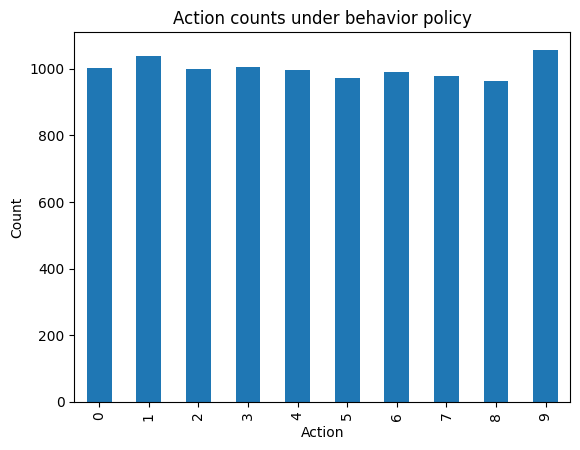

In [53]:
# Plot arm‐pull counts
df['action'].value_counts().sort_index()\
  .plot.bar(title="Action counts under behavior policy")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

All actions are chosen roughly equally, so the policy is working

In [54]:
print("Overall success rate:", df['reward'].mean())

Overall success rate: 0.6032


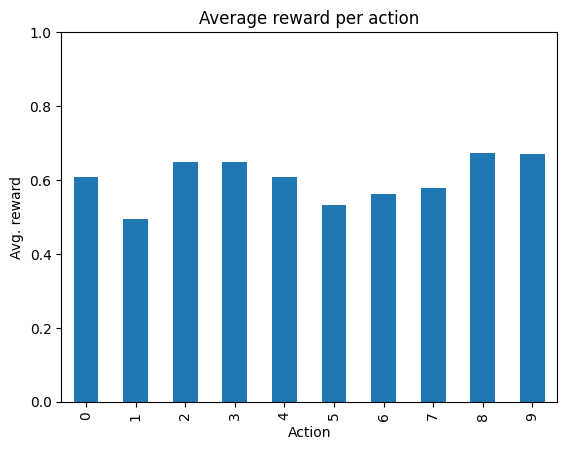

In [55]:
df.groupby('action')['reward'].mean().plot.bar(
    title="Average reward per action"
)
plt.ylim(0,1)
plt.xlabel("Action")
plt.ylabel("Avg. reward")
plt.show()

We can see that the average reward is slightly different for each arm, and an effective policy should be able to exploit the differences. With arm 1 and 5 (or 7) being the worst, and arm 9 the best. 

In [12]:
# Sample synthetic logged bandit feedback
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

print(f"Bandit feedback keys: {bandit_feedback.keys()}")
print(f"Context shape: {bandit_feedback['context'].shape}")
print(f"Average reward: {bandit_feedback['reward'].mean():.4f}")
print(f"Average expected reward: {bandit_feedback['expected_reward'].mean():.4f}")

Bandit feedback keys: dict_keys(['n_rounds', 'n_actions', 'context', 'action_context', 'action', 'position', 'reward', 'expected_reward', 'pscore'])
Context shape: (10000, 5)
Average reward: 0.6002
Average expected reward: 0.6059


### Policies evaluated

1. **LinUCB**  
   - Contextual UCB algorithm using a linear model for $q(x,a)$.  
   - Exploration bonus $\epsilon$ controls the width of the confidence interval.  
   - Variants we tried:  
     - **LinUCB (epsilon=0.0)** – pure greedy (no explicit exploration)  
     - **LinUCB (epsilon=0.1)** – light exploration  
     - **LinUCB (epsilon=0.5)** – 50% exploration, 50% exploitation

2. **LinTS**  
   - Linear Thompson Sampling:  

3. **Epsilon-Greedy (epsilon=0.1)**  
   - Fits a linear reward model.  
   - With probability $1-\varepsilon$ picks the arm with highest estimated $q(x,a)$; with probability $\varepsilon$ picks uniformly at random.

4. **Random**  
   - Always picks an arm uniformly at random (baseline for comparison).

---

Using this setup we want to understand how quickly and how well each strategy learns to choose the best arm. 


In [13]:
# Define policies
policies = {
    'LinUCB_0.0': LinUCB(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.0,  # Pure UCB
        random_state=random_state
    ),
    'LinUCB_0.1': LinUCB(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.1,
        random_state=random_state
    ),
    'LinUCB_0.5': LinUCB(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.5,
        random_state=random_state
    ),
    'LinTS': LinTS(
        dim=dim_context, 
        n_actions=n_actions, 
        random_state=random_state
    ),
    'LinEpsilonGreedy_0.1': LinEpsilonGreedy(
        dim=dim_context, 
        n_actions=n_actions, 
        epsilon=0.1,
        random_state=random_state
    )
}

print(f"Defined {len(policies)} evaluation policies:")
for name in policies.keys():
    print(f"  - {name}")

Defined 5 evaluation policies:
  - LinUCB_0.0
  - LinUCB_0.1
  - LinUCB_0.5
  - LinTS
  - LinEpsilonGreedy_0.1


In [14]:
# We want to just make sure these are roughly the same 
print(round(bandit_feedback['pscore'].mean(),2))
print(1 /n_actions)

0.1
0.1


### Run Bandit Simulations

In [15]:
print("\nRunning bandit simulation for LinUCB_0.0...")

action_dist_linucb_00 = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinUCB_0.0']
)

print("LinUCB_0.0 action distribution:")
print(f"  - Shape: {action_dist_linucb_00.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_linucb_00)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_linucb_00.sum(axis=1))}")


Running bandit simulation for LinUCB_0.0...


100%|██████████| 10000/10000 [00:00<00:00, 20684.62it/s]

LinUCB_0.0 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [16]:
print("\nRunning bandit simulation for LinUCB_0.1...")

action_dist_linucb_01 = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinUCB_0.1']
)

print("LinUCB_0.1 action distribution:")
print(f"  - Shape: {action_dist_linucb_01.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_linucb_01)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_linucb_01.sum(axis=1))}")


Running bandit simulation for LinUCB_0.1...


100%|██████████| 10000/10000 [00:00<00:00, 21941.76it/s]

LinUCB_0.1 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [17]:
print("\nRunning bandit simulation for LinUCB_0.5...")

action_dist_linucb_05 = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinUCB_0.5']
)

print("LinUCB_0.5 action distribution:")
print(f"  - Shape: {action_dist_linucb_05.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_linucb_05)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_linucb_05.sum(axis=1))}")



Running bandit simulation for LinUCB_0.5...


100%|██████████| 10000/10000 [00:00<00:00, 19353.36it/s]

LinUCB_0.5 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [18]:
print("\nRunning bandit simulation for LinTS...")

action_dist_lints = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinTS']
)

print("LinTS action distribution:")
print(f"  - Shape: {action_dist_lints.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_lints)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_lints.sum(axis=1))}")



Running bandit simulation for LinTS...


100%|██████████| 10000/10000 [00:03<00:00, 3203.55it/s]

LinTS action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [19]:
print("\nRunning bandit simulation for LinEpsilonGreedy_0.1...")

action_dist_lineps = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=policies['LinEpsilonGreedy_0.1']
)

print("LinEpsilonGreedy_0.1 action distribution:")
print(f"  - Shape: {action_dist_lineps.shape}")
print(f"  - Non-zero entries: {np.count_nonzero(action_dist_lineps)}")
print(f"  - Rounds with actions: {np.count_nonzero(action_dist_lineps.sum(axis=1))}")


Running bandit simulation for LinEpsilonGreedy_0.1...


100%|██████████| 10000/10000 [00:00<00:00, 52857.54it/s]

LinEpsilonGreedy_0.1 action distribution:
  - Shape: (10000, 10, 1)
  - Non-zero entries: 10000
  - Rounds with actions: 10000


In [20]:
action_distributions = {
    'LinUCB_0.0': action_dist_linucb_00,
    'LinUCB_0.1': action_dist_linucb_01,
    'LinUCB_0.5': action_dist_linucb_05,
    'LinTS': action_dist_lints,
    'LinEpsilonGreedy_0.1': action_dist_lineps
}

print("\nAction distributions summary:")
for name, dist in action_distributions.items():
    active_rounds = np.count_nonzero(dist.sum(axis=1))
    print(f"  - {name}: {active_rounds}/{n_rounds} active rounds")



Action distributions summary:
  - LinUCB_0.0: 10000/10000 active rounds
  - LinUCB_0.1: 10000/10000 active rounds
  - LinUCB_0.5: 10000/10000 active rounds
  - LinTS: 10000/10000 active rounds
  - LinEpsilonGreedy_0.1: 10000/10000 active rounds


### Calculate ground truth values 

In real-world datasets, we would not know the actual ground truth, however using the synthetically created bandit algorithm, we can calculate for each policy, how would the reward be for this specfic action-context pair that our policy chooses, and hence calculate the cumulative reward for each policy

In [21]:
ground_truth_values = {}

for policy_name, policy in policies.items():
    print(f"Computing ground truth for {policy_name}...")
    
    ground_truth_policy_value = calc_ground_truth_policy_value(
        bandit_feedback=bandit_feedback,
        reward_sampler=dataset.sample_reward,  # the true reward function
        policy=policy,
        n_sim=n_sim  # number of simulations - changed this to 50 cause before we got too varying estimates 
    )
    
    ground_truth_values[policy_name] = ground_truth_policy_value
    print(f"  Ground truth value: {ground_truth_policy_value:.4f}")

print("\nGround truth ranking:")
sorted_policies = sorted(ground_truth_values.items(), key=lambda x: x[1], reverse=True)
for i, (policy_name, value) in enumerate(sorted_policies, 1):
    print(f"  {i}. {policy_name}: {value:.4f}")


Computing ground truth for LinUCB_0.0...


100%|██████████| 50/50 [01:40<00:00,  2.00s/it]


  Ground truth value: 0.7197
Computing ground truth for LinUCB_0.1...


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


  Ground truth value: 0.7293
Computing ground truth for LinUCB_0.5...


100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


  Ground truth value: 0.7317
Computing ground truth for LinTS...


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]


  Ground truth value: 0.7015
Computing ground truth for LinEpsilonGreedy_0.1...


100%|██████████| 50/50 [01:22<00:00,  1.65s/it]

  Ground truth value: 0.7138

Ground truth ranking:
  1. LinUCB_0.5: 0.7317
  2. LinUCB_0.1: 0.7293
  3. LinUCB_0.0: 0.7197
  4. LinEpsilonGreedy_0.1: 0.7138
  5. LinTS: 0.7015


### Off-Policy Evaluation Replay Method & Doubly Robust Estimator 

In this section we assess how each policy would have performed on our logged data without running it live. We use two different off-policy evaluation estimators to obtain robust, unbiased estimates of each policy's expected reward. We compare these estimates to the random baseline to understand relative performance across different contextual bandit policies

In [22]:
# Could try others too
from obp.ope import OffPolicyEvaluation, ReplayMethod, DoublyRobust

When we get the expected reward it gets output in the shape (T,K) but we need (T,K,1) to match with the action distribution vector.

In [23]:
# shape fix function
def fix_shapes(action_dist, Q_hat):
    """Ensure action_dist and Q_hat have compatible shapes for OBP"""
    if len(action_dist.shape) == 3 and action_dist.shape[2] == 1:
        # If action_dist is (T, K, 1), expand Q_hat to match
        return action_dist, np.expand_dims(Q_hat, axis=2)

In [24]:
# Get the expected rewards and create evaluator
Q_hat = bandit_feedback['expected_reward']
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[ReplayMethod(), DoublyRobust()]
)

# Evaluate all policies
results = {}
print("Policy Evaluation Results:")
print("-" * 50)

for name, action_dist in action_distributions.items():
    # Fix shapes automatically
    action_dist_fixed, Q_hat_fixed = fix_shapes(action_dist, Q_hat)
    
    # Evaluate policy
    estimates = ope.estimate_policy_values(
        action_dist=action_dist_fixed,
        estimated_rewards_by_reg_model=Q_hat_fixed
    )
    
    results[name] = estimates
    print(f"{name:20} | Replay: {estimates['rm']:.4f} | DR: {estimates['dr']:.4f}")

# Summary
baseline = bandit_feedback['reward'].mean()
best_policy = max(results.keys(), key=lambda x: results[x]['dr'])

print(f"\nBaseline (Random):      {baseline:.4f}")
print(f"Best Policy:            {best_policy} (DR: {results[best_policy]['dr']:.4f})")
print(f"Improvement:            {((results[best_policy]['dr'] / baseline) - 1) * 100:.1f}%")

Policy Evaluation Results:
--------------------------------------------------
LinUCB_0.0           | Replay: 0.6498 | DR: 0.6586
LinUCB_0.1           | Replay: 0.6365 | DR: 0.6412
LinUCB_0.5           | Replay: 0.6762 | DR: 0.6793
LinTS                | Replay: 0.6100 | DR: 0.6309
LinEpsilonGreedy_0.1 | Replay: 0.6687 | DR: 0.6773

Baseline (Random):      0.6002
Best Policy:            LinUCB_0.5 (DR: 0.6793)
Improvement:            13.2%


### Online Policy Simulation

In [25]:
def create_policy(policy_name):
    """Factory function to create policies"""
    if 'LinUCB' in policy_name:
        if '0.0' in policy_name:
            return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.0, random_state=random_state)
        elif '0.1' in policy_name:
            return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=random_state)
        elif '0.5' in policy_name:
            return LinUCB(dim=dim_context, n_actions=n_actions, epsilon=0.5, random_state=random_state)
    elif 'LinTS' in policy_name:
        return LinTS(dim=dim_context, n_actions=n_actions, random_state=random_state)
    elif 'LinEpsilonGreedy' in policy_name:
        return LinEpsilonGreedy(dim=dim_context, n_actions=n_actions, epsilon=0.1, random_state=random_state)
    else:
        raise ValueError(f"Unknown policy: {policy_name}")

def simulate_learning(bandit_feedback, policy_name):
    """Simulate policy learning"""
    n_rounds = bandit_feedback['n_rounds']
    contexts = bandit_feedback['context']
    cumulative_rewards = np.zeros(n_rounds)
    
    # Create fresh policy
    policy = create_policy(policy_name)
    
    # Run simulation
    for t in range(n_rounds):
        context = contexts[t:t+1]
        action = policy.select_action(context)[0]
        reward = dataset.sample_reward(context, np.array([action]))[0]
        
        # Update policy
        policy.update_params(action=action, reward=reward, context=context)
        
        # Track cumulative reward
        cumulative_rewards[t] = cumulative_rewards[t-1] + reward if t > 0 else reward
    
    return cumulative_rewards

In [26]:
policy_names = list(action_distributions.keys())

print("Simulating learning for all policies...")
learning_curves = {}
for name in policy_names:
    print(f"  {name}...")
    learning_curves[name] = simulate_learning(bandit_feedback, name)

print("\nFinal performance (average reward per round):")
for name, rewards in learning_curves.items():
    avg_reward = rewards[-1] / len(rewards)  # More robust than using n_rounds
    print(f"{name:20}: {avg_reward:.4f}")

Simulating learning for all policies...
  LinUCB_0.0...
  LinUCB_0.1...
  LinUCB_0.5...
  LinTS...
  LinEpsilonGreedy_0.1...

Final performance (average reward per round):
LinUCB_0.0          : 0.7140
LinUCB_0.1          : 0.7122
LinUCB_0.5          : 0.7316
LinTS               : 0.7247
LinEpsilonGreedy_0.1: 0.7283


### Regret Analysis

In [33]:
def calculate_regret(bandit_feedback, learning_curves):
    """Calculate cumulative regret for each policy"""
    n_rounds = bandit_feedback['n_rounds']
    contexts = bandit_feedback['context']
    
    # Calculate optimal reward for each round
    optimal_rewards = []
    for t in range(n_rounds):
        context = contexts[t:t+1]
        # Get rewards for all actions for this context
        all_rewards = []
        for action in range(n_actions):
            reward = dataset.sample_reward(context, np.array([action]))[0]
            all_rewards.append(reward)
        optimal_rewards.append(max(all_rewards))
    
    optimal_cumulative = np.cumsum(optimal_rewards)
    
    regret_curves = {}
    for name, cumulative_rewards in learning_curves.items():
        regret_curves[name] = optimal_cumulative - cumulative_rewards
    
    return regret_curves, optimal_cumulative

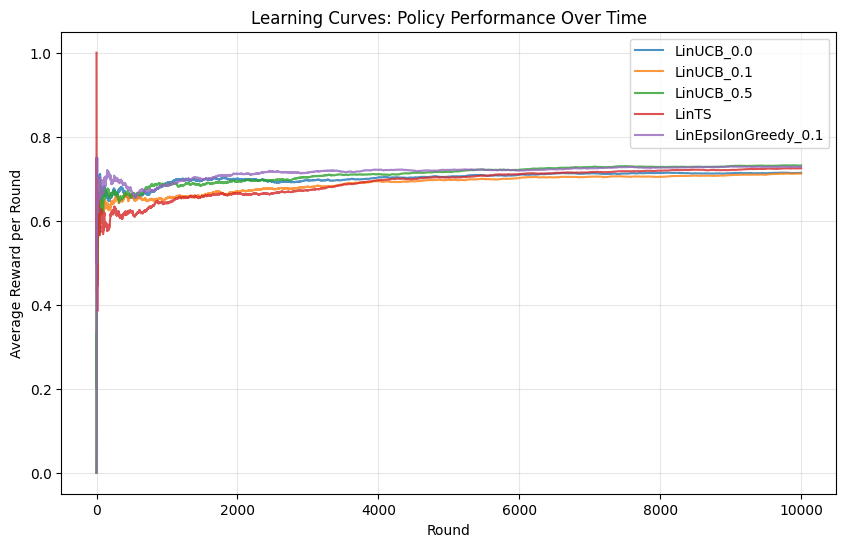

In [27]:
plt.figure(figsize=(10, 6))
for name, rewards in learning_curves.items():
    # Convert cumulative to average reward per round
    avg_rewards = rewards / np.arange(1, len(rewards) + 1)
    plt.plot(avg_rewards, label=name, alpha=0.8)

plt.xlabel('Round')
plt.ylabel('Average Reward per Round')
plt.title('Learning Curves: Policy Performance Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
# Color scheme 
colors = {
    'LinUCB_0.0': '#1f77b4',      # Blue
    'LinUCB_0.1': '#ff7f0e',      # Orange  
    'LinUCB_0.5': '#2ca02c',      # Green
    'LinTS': '#d62728',           # Red
    'LinEpsilonGreedy_0.1': '#9467bd'  # Purple
}

policy_names = list(policies.keys())

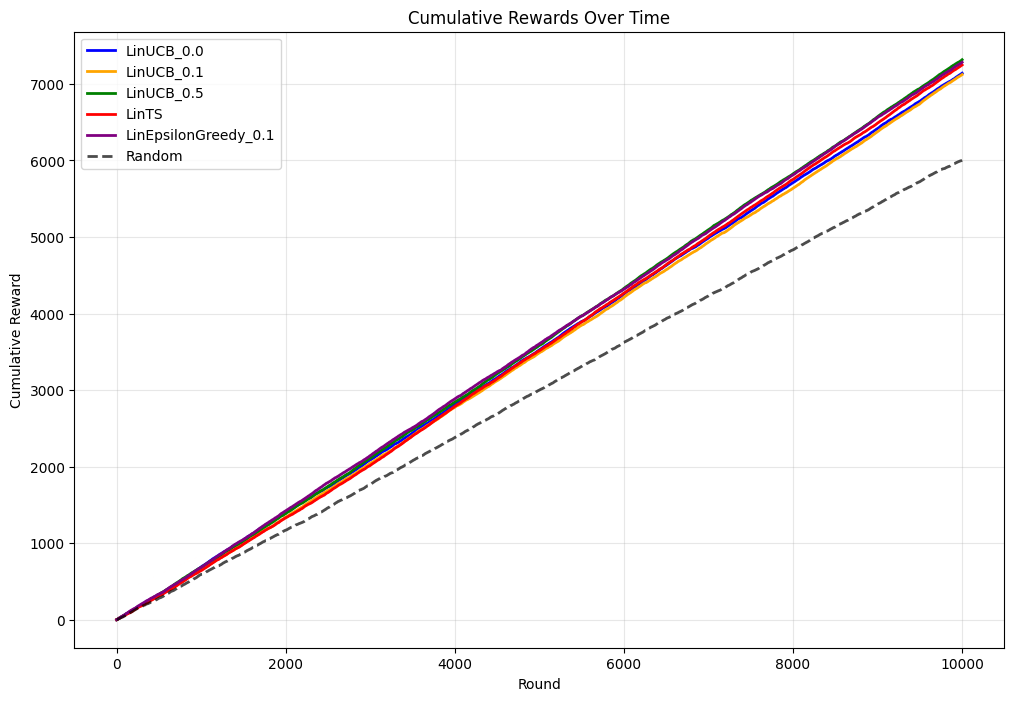

In [29]:
# Plot 1: Cumulative Rewards
plt.figure(figsize=(12, 8))
rounds = np.arange(1, n_rounds + 1)

colors = {'LinUCB_0.0': 'blue', 'LinUCB_0.1': 'orange', 'LinUCB_0.5': 'green', 
          'LinTS': 'red', 'LinEpsilonGreedy_0.1': 'purple'}

for name, rewards in learning_curves.items():
    plt.plot(rounds, rewards, label=name, color=colors[name], linewidth=2)

plt.plot(rounds, np.cumsum(bandit_feedback['reward']), '--', 
         color='black', alpha=0.7, label='Random', linewidth=2)

plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

From the cumulative reward plot, we can see that all policies outperform the random policy. 

Surprisingly, running the results several times, gave different outcomes for which policy performs better, suggesting that each time we ran the experiment, a different policy ended up the winner, which suggests that these 10,000 rounds may not be enough to determine a clear winner, and the experiment would need to be run a larger sample. However, to keep things comparable to the real data, we did not opt to do this. 

To understand to what extent the algorithms are learning over time, we can aggregate the average reward over a 500-round window, and check how this moving average evolves acorss the rounds, to observe the learning process. 

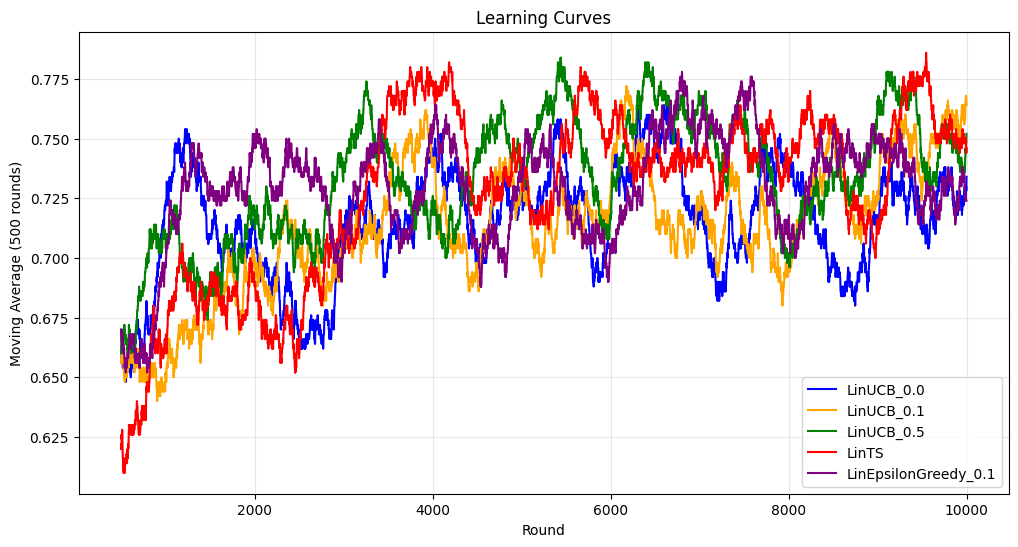

In [30]:
plt.figure(figsize=(12, 6))
window = 500

for name, cumulative in learning_curves.items():
    rewards = np.diff(np.concatenate([[0], cumulative]))
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    x = np.arange(window, len(rewards) + 1)
    plt.plot(x, moving_avg, label=name, color=colors[name])

plt.xlabel('Round')
plt.ylabel(f'Moving Average ({window} rounds)')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Insights**

- It seems that each of the policies learn similar things 
- We can see that pure UCB_0.0 shoots up early, however seems to perform worse in the long term 
- And ultimately, UCB_0.1 averages highest rewards in the final windows, possibly hinting that if we had more round then we would still see some overall more clear outcomes 
- However, it also seems clear that towards the end of the rounds, all polciies seem to converge to a similar moving average

We can also plot the overall comparison between the methods on average reward. 

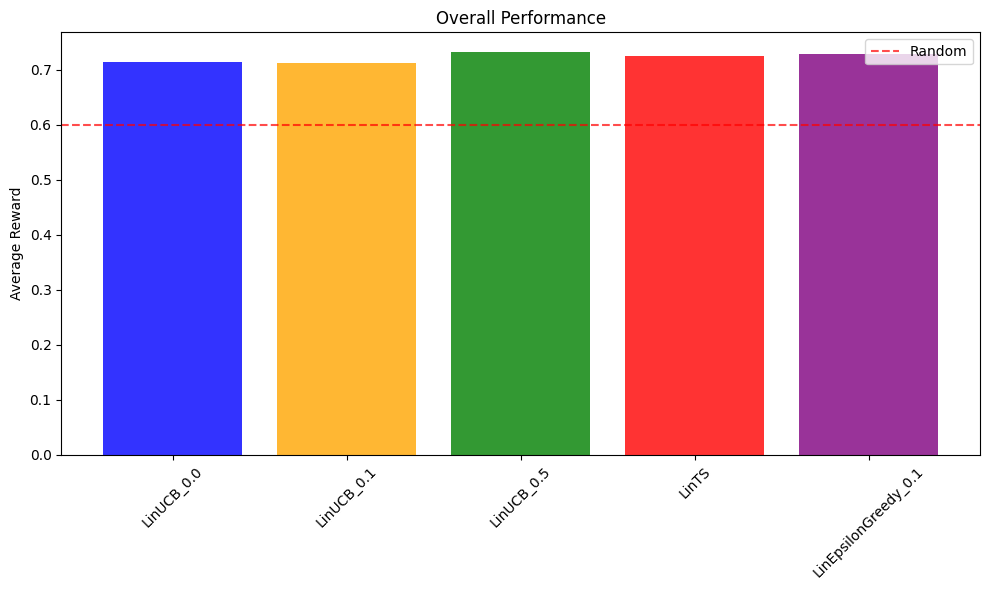

In [31]:
plt.figure(figsize=(10, 6))
names = list(learning_curves.keys())
final_rewards = [learning_curves[name][-1]/n_rounds for name in names]

plt.bar(names, final_rewards, color=[colors[name] for name in names], alpha=0.8)
plt.axhline(y=bandit_feedback['reward'].mean(), color='red', linestyle='--', 
            alpha=0.7, label='Random')
plt.ylabel('Average Reward')
plt.title('Overall Performance')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Finally, we can plot the arm choices by each policy and observe which rms are being picked most frequently by which policy. 

In [56]:
 # Calculate true average reward for each arm (across all contexts)
arm_rewards = []
sample_contexts = bandit_feedback['context'][:1000]  # Sample for efficiency
for arm in range(10):
    rewards = []
    for context in sample_contexts:
        reward = dataset.sample_reward(context.reshape(1,-1), np.array([arm]))[0]
        rewards.append(reward)
    arm_rewards.append(np.mean(rewards))

print("True average reward by arm:", [f"{r:.4f}" for r in arm_rewards])
print("Best arm:", np.argmax(arm_rewards), f"(reward: {max(arm_rewards):.4f})")

True average reward by arm: ['0.5910', '0.5220', '0.6550', '0.6430', '0.6110', '0.5090', '0.6010', '0.5670', '0.6560', '0.6780']
Best arm: 9 (reward: 0.6780)


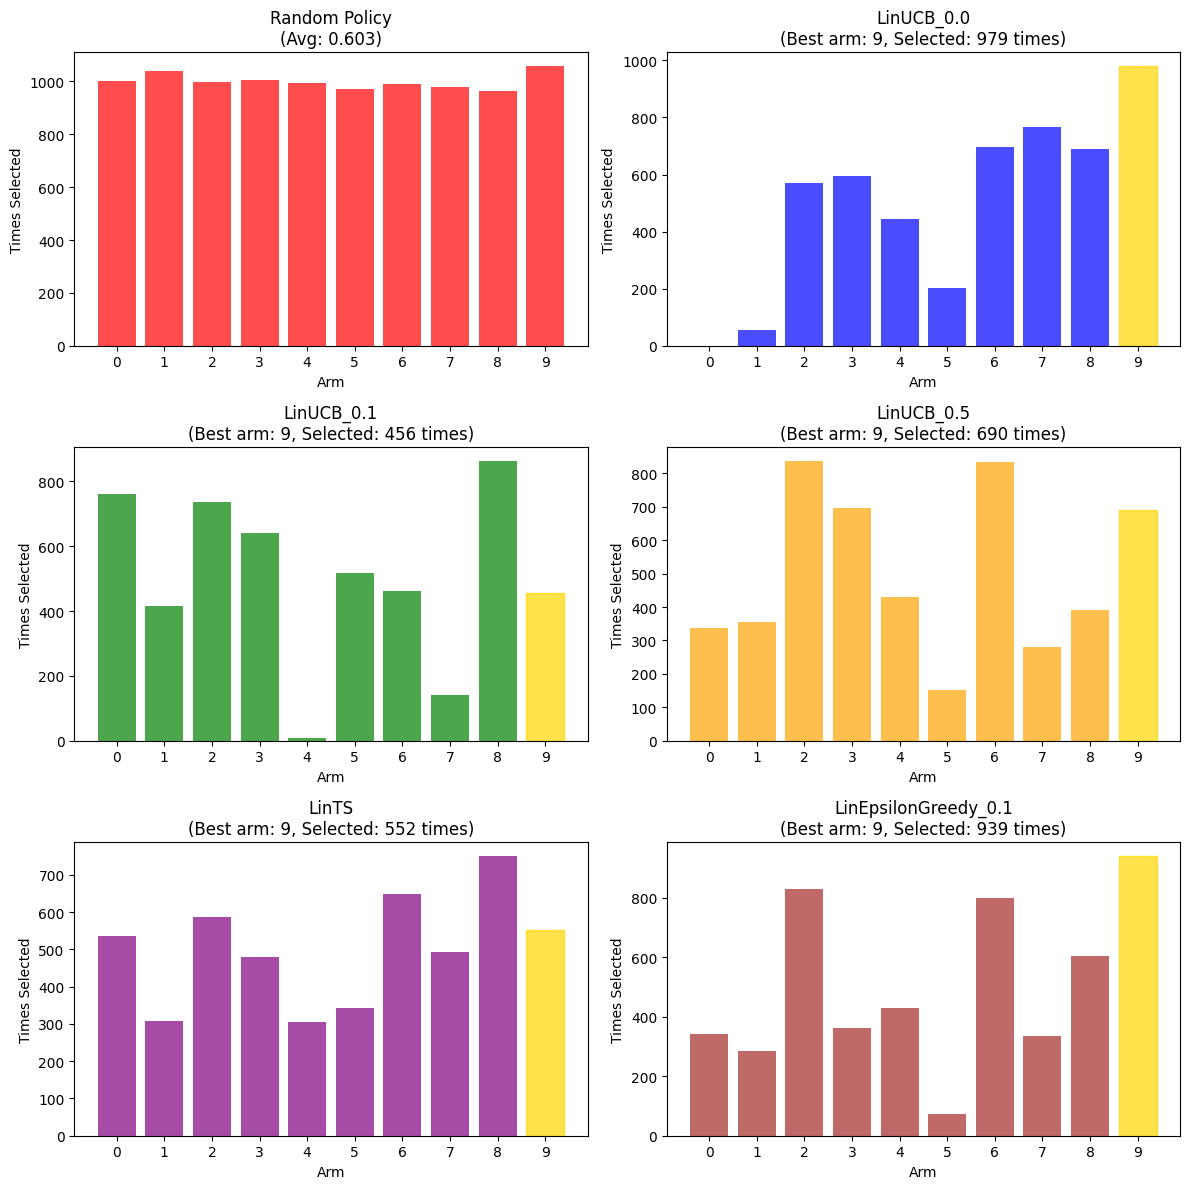

In [57]:
from collections import Counter

# Get random policy data
logged_actions = bandit_feedback['action']
logged_counts = Counter(logged_actions)

# Quick sim for ALL learning policies
policy_data = {}
for policy_name in list(action_distributions.keys()): 
    policy = create_policy(policy_name)
    actions = []
    
    for t in range(5000):  
        context = bandit_feedback['context'][t:t+1]
        action = policy.select_action(context)[0]
        reward = dataset.sample_reward(context, np.array([action]))[0]
        actions.append(action)
        policy.update_params(action, reward, context)
    
    policy_data[policy_name] = Counter(actions)

# Plot all together (1 random + all learning policies)
n_policies = len(policy_data) + 1
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Random policy
arms = range(10)
counts = [logged_counts.get(arm, 0) for arm in arms]
axes[0].bar(arms, counts, alpha=0.7, color='red')
axes[0].set_title(f'Random Policy\n(Avg: {bandit_feedback["reward"].mean():.3f})')

# All learning policies
colors = ['blue', 'green', 'orange', 'purple', 'brown']
# Modify your plotting code to include arm quality
for i, (name, counter) in enumerate(policy_data.items()):
    counts = [counter.get(arm, 0) for arm in arms]
    ax = axes[i+1]
    bars = ax.bar(arms, counts, alpha=0.7, color=colors[i % len(colors)])
    
    # Color bars by arm quality
    best_arm = np.argmax(arm_rewards)
    bars[best_arm].set_color('gold')  # Highlight best arm
    
    ax.set_title(f'{name}\n(Best arm: {best_arm}, Selected: {counter.get(best_arm, 0)} times)')

for ax in axes:
    ax.set_xlabel('Arm')
    ax.set_ylabel('Times Selected')
    ax.set_xticks(arms)

plt.tight_layout()
plt.show()

UCB_0.1 seems to almost never pick arms 1 and 5 which are the worst arms as we saw earlier. However, does still pick arm 7 a good amount of times. 